# Imports

In [1]:
import numpy as np

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import auc

from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# filtering messages to error
import warnings

warnings.filterwarnings('ignore')

# Utils

In [3]:
def read_file(filename):
    tmp = list()
    with open(filename) as f:
        for line in f:
            if len(line.rstrip()) == 0:
                continue
            tmp.append([float(i) for i in line.rstrip().split(',')])
    return tmp

## Graphs

In [4]:
def draw_graph(values, algorithm, title, 
               y_label, x_label='Number of Elements', 
               errors=False, single_tech=False, save_fig=False):    
    '''
        The lists have the following format:
        
        list = [
            [
                [],  # random-forest
                [],  # gradient-boosting
                [],  # logistic-regression
                [],  # mvc
                []   # mlp
            ],  # active-semi 
            [ ... ],  # active-super
            [ ... ],  # random-semi
            [ ... ]   # random-super
        ]
    '''
    
    score, std = values
    
    _score = [i[algorithm] for i in score]
    _std   = [i[algorithm] for i in std]
    
    _labels = TECHS
    
    if single_tech:
        _score = score[algorithm]
        _std = std[algorithm]
        
        _labels = LEARNERS

    fig, ax = plt.subplots(figsize=(8, 6))
    
    if errors:
        # show error bars
        for y, std, label in zip(_score, _std, _labels):         
            legend = f'{label} (auc={auc(np.linspace(0, 1, 100), y):.2f})'
            errors = [np.array(y) - np.array(std), np.array(y) + np.array(std)]
            ax.errorbar(RANGES, y, yerr=errors, fmt='-', alpha=0.9, capsize=4, label=legend)
    else:
        for y, label in zip(_score, _labels):
            legend = f'{label} (auc={auc(np.linspace(0, 1, 100), y):.2f})'
            ax.plot(RANGES, y, label=legend)
        
    ax.set_title(title, size=12)
    ax.set_xlabel(x_label, size=12)
    ax.set_ylabel(y_label, size=12)
    ax.grid(color='0.95')
    ax.legend()
    
    if save_fig:
        plt.savefig('active-learning-curve.pdf', format='pdf', dpi=1200, bbox_inches='tight')
        plt.show()

In [5]:
def draw_graph_side(first, last, algorithm, suptitle, titles, y_labels, labels, colors, errors=False):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True, sharey=True)
    
    values = [first, last]  
        
    fig.suptitle(suptitle) 
        
    for ax, (scores, stds), title, y_label, label, color in zip(axes, values, titles, y_labels, labels, colors):
        _score = [i[algorithm] for i in scores]
        _std = [i[algorithm] for i in stds]

        if errors:
            for y, std, lab, col in zip(_score, _std, label, color):
                errors = [np.array(y) - np.array(std), np.array(y) + np.array(std)]
                ax.errorbar(RANGES, y, yerr=errors, fmt='-', alpha=0.9, capsize=4, label=lab, color=col)
        else:
            for y, lab, col in zip(_score, label, color):
                ax.plot(RANGES, y, label=lab, color=col)

        ax.set_title(title, size=12)
        ax.set_xlabel('number of elements', size=12)
        ax.set_ylabel(y_label, size=12)
        ax.grid(color='0.95')
        ax.legend()

In [6]:
def plot_confusion_matrix(cms, tech, algo):
    
    labels = ['LOW', 'MEDIUM', 'HIGH', 'CRITICAL']
    titles = ['#20 elem.', 'Mean', '#100 elem.']
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
    
    fig.suptitle(f'{TECHS[tech]} - {LEARNERS[algo].upper()} CM', size=14)
    
    for index, (axe, cm_values, title) in enumerate(zip(axes, cms, titles)):
        cm = np.ndarray(shape=(4,4), dtype=float)
        begin = 0
        for row in range(4):           
            cm[row, ] = cm_values[tech][algo][begin:begin + 4]
            begin += 4
        
        yticks = labels if index == 0 else False
        draw_cbar = True if index == 2 else False
        
        axe.set_title(title)
        axe = sns.heatmap(cm, ax=axe, annot=True, fmt=".2f", linewidths=.5, cmap=plt.cm.Blues, 
                          yticklabels=yticks, xticklabels=labels, cbar=draw_cbar)
        
        axe.set_xticklabels(axe.get_xticklabels(), rotation=45)
        axe.set_yticklabels(axe.get_yticklabels(), rotation=0)
    plt.show()

In [7]:
def find_best_classifier(accs):
    classifiers_names = ['rf', 'gb', 'lr', 'svc', 'mlp']

    for i, n_elem in enumerate(RANGES):
        best_tech = ''
        best_classifier = ''
        max_acc = 0
        for test_index, classifiers in enumerate(accs):
            for learner_index, classifier in enumerate(classifiers):
                curr_acc = classifier[i]
                if curr_acc > max_acc:
                    max_acc = curr_acc
                    best_tech = TECHS[test_index]
                    best_classifier = LEARNERS[learner_index]
                    
        if i % 10 == 0 or i == len(RANGES) - 1:
            print(f'For #{n_elem} elements, the best classifier is {best_classifier.upper()} using {best_tech} with {max_acc:.2f} score.')

In [8]:
def print_statistics(accs, index):
    learner_results = [i[index] for i in accs]
    for n_elem, size in enumerate(RANGES):
       
        curr_acc = [i[n_elem] for i in learner_results]
        best = TECHS[curr_acc.index(max(curr_acc))]
        
        if n_elem % 10 == 0 or n_elem == len(RANGES) - 1:
            print(f'#{size} elements: max acc = {max(curr_acc):.2f} => best: {best}')

## Results

In [9]:
FILES = ['active-super-strategies']

QUERY_METHOD = ['query', 'committee']

STRATEGIES = [
    ['entropy-sampling', 'uncertainty-sampling'],
    ['kl-max-disagreement', 'vote-entropy-sampling']
]

LEARNERS = ['rf', 'gb', 'lr', 'svc', 'mlp']

TECHS = [
    'query-entropy-sampling', 'query-uncertainty-sampling', 
    'committee-kl-max-disagreement', 'committee-vote-entropy-sampling'
]

In [10]:
RANGES = [i for i in range(100)]

In [11]:
ACTIVE_SUPER = 0

RF = 0
GB = 1
LR = 2
SVC = 3
MLP = 4

In [12]:
results_path = '../results/compiled'

In [13]:
# initializing lists

accs, accs_std = list(), list()
times, times_std = list(), list()

precisions, precisions_std = list(), list()
recalls, recalls_std = list(), list()
f1s, f1s_std = list(), list()

cms, cms_lower, cms_upper = list(), list(), list()

In [14]:
# reading results from file

for query_name, strategies in zip(QUERY_METHOD, STRATEGIES):
    for strategy in strategies:
        
        base_url = f'{results_path}/{query_name}-{strategy}'
        
        accs.append(read_file(f'{base_url}-accs-mean.txt'))
        accs_std.append(read_file(f'{base_url}-accs-std.txt'))

        times.append(read_file(f'{base_url}-times-mean.txt'))
        times_std.append(read_file(f'{base_url}-times-std.txt'))

        precisions.append(read_file(f'{base_url}-precisions-mean.txt'))
        precisions_std.append(read_file(f'{base_url}-precisions-std.txt'))

        recalls.append(read_file(f'{base_url}-recalls-mean.txt'))
        recalls_std.append(read_file(f'{base_url}-recalls-std.txt'))

        f1s.append(read_file(f'{base_url}-f1s-mean.txt'))
        f1s_std.append(read_file(f'{base_url}-f1s-std.txt'))

        cms.append(read_file(f'{base_url}-cms-mean.txt'))
        cms_lower.append(read_file(f'{base_url}-cms-lower.txt'))
        cms_upper.append(read_file(f'{base_url}-cms-upper.txt'))

In [15]:
# creating scores lists

acc_list = [accs, accs_std]
time_list = [times, times_std]

precision_list = [precisions, precisions_std]
recall_list = [recalls, recalls_std]
f1_list = [f1s, f1s_std]

cm_list = [cms_lower, cms, cms_upper]

In [16]:
scores, stds = acc_list

query = [scores[:2], stds[:2]]
committee = [scores[2:], stds[2:]]

TITLES = ['Query', 'Committee']
Y_LABELS = ['accuracy', '']
LABELS = [TECHS[:2], TECHS[2:]]
COLORS = [['#1f77b4', '#ff7f0e', '#2ca02c'], ['#d62728', '#9467bd', '#8c564b']]

## RF Classifier

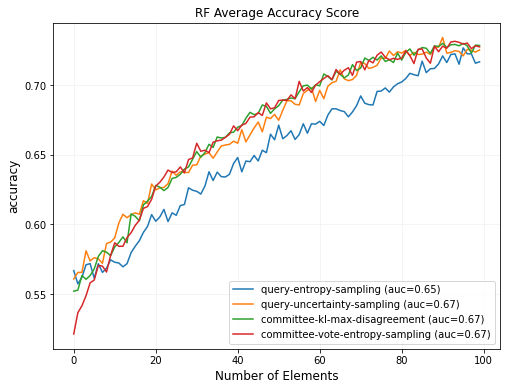

In [17]:
draw_graph(acc_list, algorithm=RF, title='RF Average Accuracy Score', y_label='accuracy')

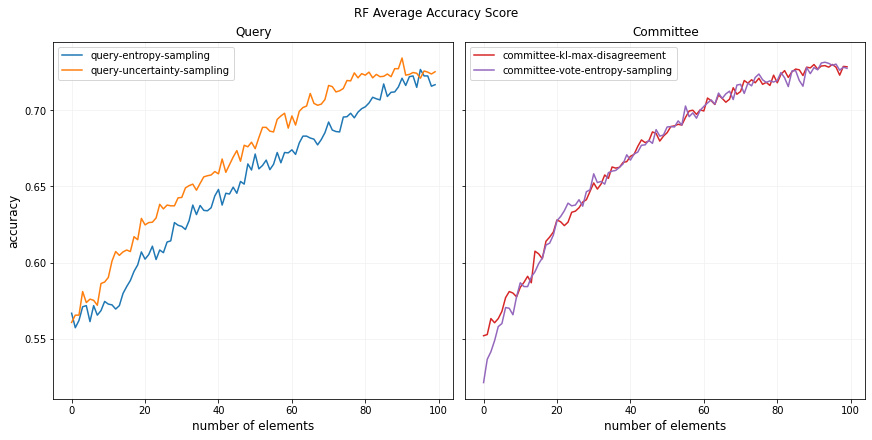

In [18]:
draw_graph_side(query, committee, 
                algorithm=RF, suptitle='RF Average Accuracy Score', 
                titles=TITLES, y_labels=Y_LABELS, labels=LABELS, colors=COLORS, errors=False)

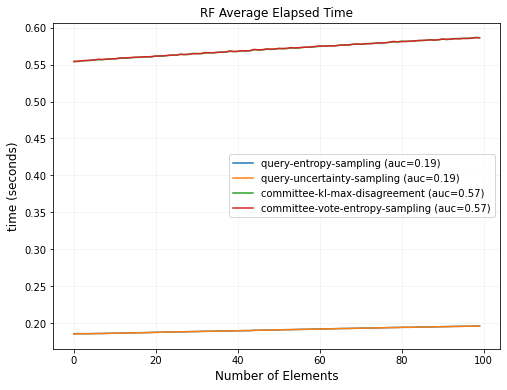

In [19]:
draw_graph(time_list, algorithm=RF, title='RF Average Elapsed Time', y_label='time (seconds)')

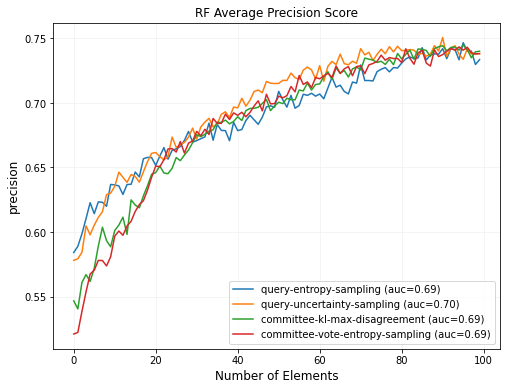

In [20]:
draw_graph(precision_list, algorithm=RF, title='RF Average Precision Score', y_label='precision')

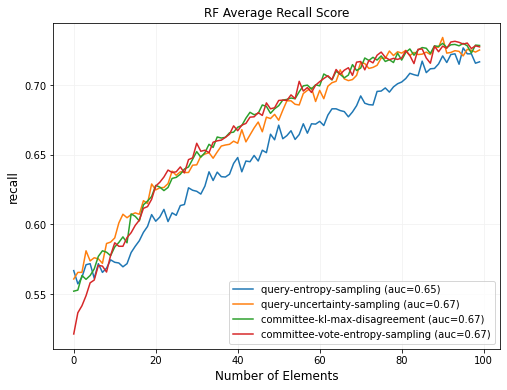

In [21]:
draw_graph(recall_list, algorithm=RF, title='RF Average Recall Score', y_label='recall')

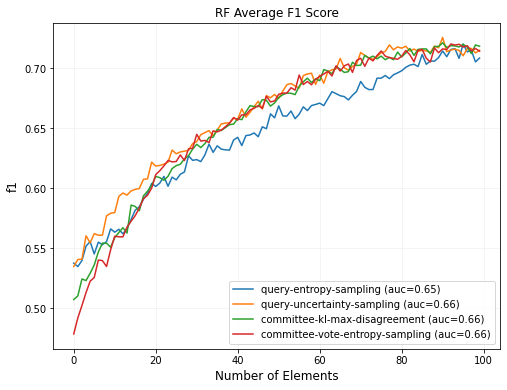

In [22]:
draw_graph(f1_list, algorithm=RF, title='RF Average F1 Score', y_label='f1')

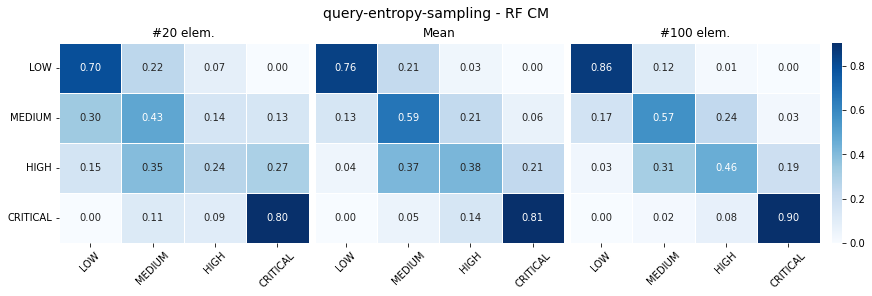

In [23]:
plot_confusion_matrix(cm_list, tech=ACTIVE_SUPER, algo=RF)

In [24]:
print_statistics(accs, RF)

#0 elements: max acc = 0.57 => best: query-entropy-sampling
#10 elements: max acc = 0.59 => best: query-uncertainty-sampling
#20 elements: max acc = 0.63 => best: committee-kl-max-disagreement
#30 elements: max acc = 0.66 => best: committee-vote-entropy-sampling
#40 elements: max acc = 0.67 => best: committee-kl-max-disagreement
#50 elements: max acc = 0.69 => best: committee-vote-entropy-sampling
#60 elements: max acc = 0.70 => best: committee-vote-entropy-sampling
#70 elements: max acc = 0.72 => best: committee-vote-entropy-sampling
#80 elements: max acc = 0.72 => best: query-uncertainty-sampling
#90 elements: max acc = 0.73 => best: query-uncertainty-sampling
#99 elements: max acc = 0.73 => best: committee-kl-max-disagreement


## GB Classifier

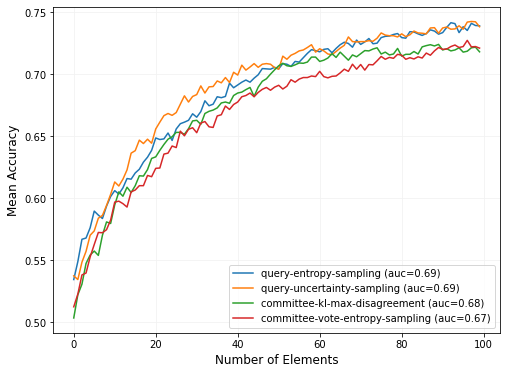

In [25]:
draw_graph(acc_list, algorithm=GB, title='', 
           y_label='Mean Accuracy', x_label='Number of Elements', save_fig=True)

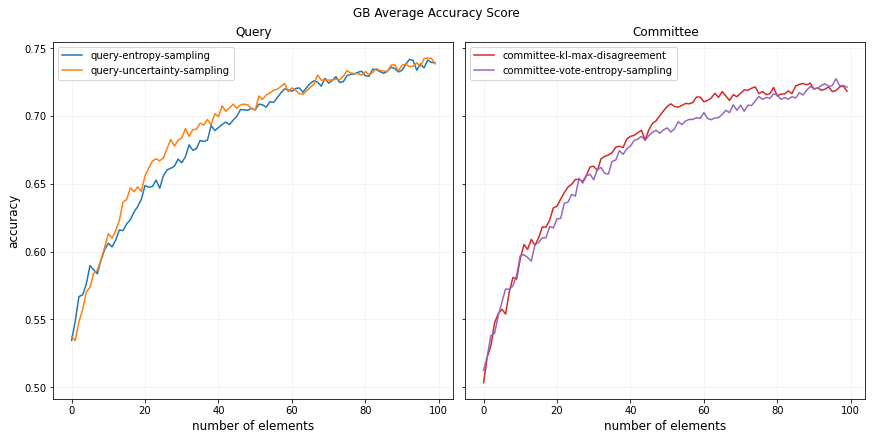

In [26]:
draw_graph_side(query, committee, 
                algorithm=GB, suptitle='GB Average Accuracy Score', 
                titles=TITLES, y_labels=Y_LABELS, labels=LABELS, colors=COLORS, errors=False)

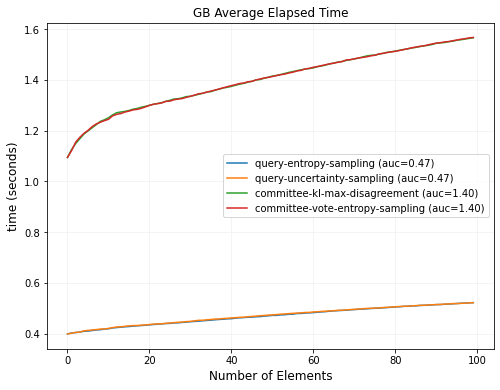

In [27]:
draw_graph(time_list, algorithm=GB, title='GB Average Elapsed Time', y_label='time (seconds)')

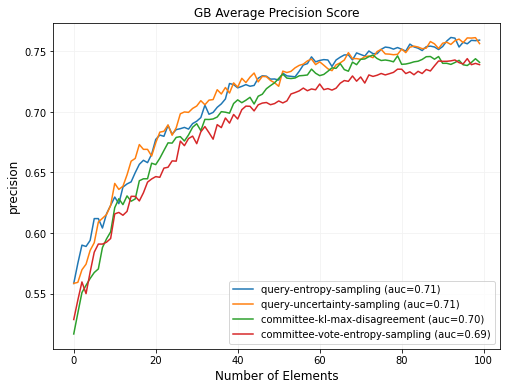

In [28]:
draw_graph(precision_list, algorithm=GB, title='GB Average Precision Score', y_label='precision')

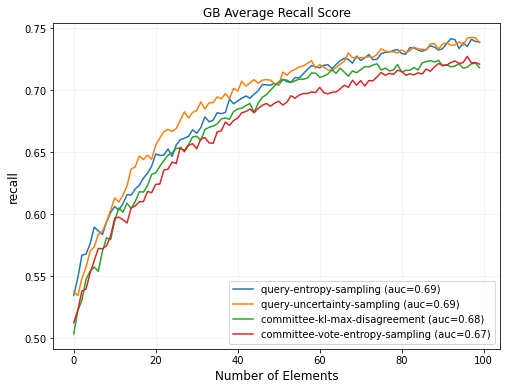

In [29]:
draw_graph(recall_list, algorithm=GB, title='GB Average Recall Score', y_label='recall')

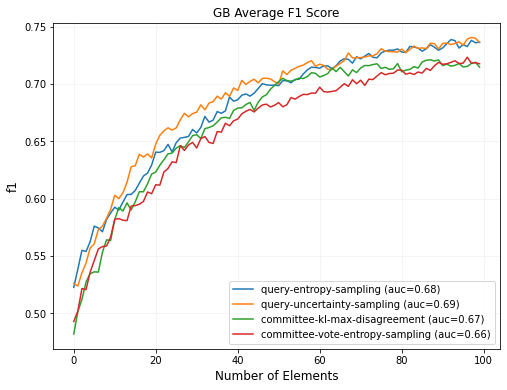

In [30]:
draw_graph(f1_list, algorithm=GB, title='GB Average F1 Score', y_label='f1')

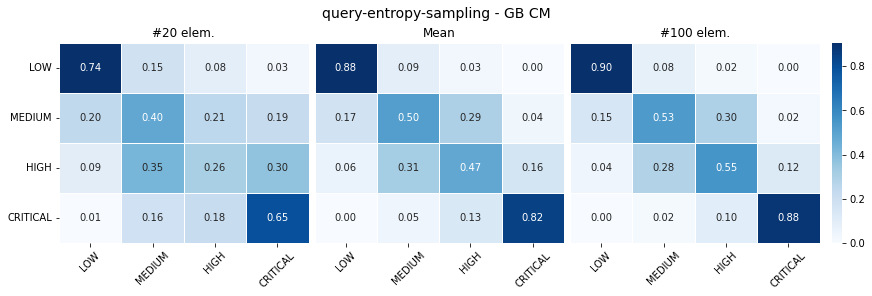

In [31]:
plot_confusion_matrix(cm_list, tech=ACTIVE_SUPER, algo=GB)

In [32]:
print_statistics(accs, GB)

#0 elements: max acc = 0.54 => best: query-uncertainty-sampling
#10 elements: max acc = 0.61 => best: query-uncertainty-sampling
#20 elements: max acc = 0.66 => best: query-uncertainty-sampling
#30 elements: max acc = 0.68 => best: query-uncertainty-sampling
#40 elements: max acc = 0.70 => best: query-uncertainty-sampling
#50 elements: max acc = 0.71 => best: committee-kl-max-disagreement
#60 elements: max acc = 0.72 => best: query-uncertainty-sampling
#70 elements: max acc = 0.73 => best: query-uncertainty-sampling
#80 elements: max acc = 0.73 => best: query-uncertainty-sampling
#90 elements: max acc = 0.74 => best: query-uncertainty-sampling
#99 elements: max acc = 0.74 => best: query-entropy-sampling


## LR Classifier

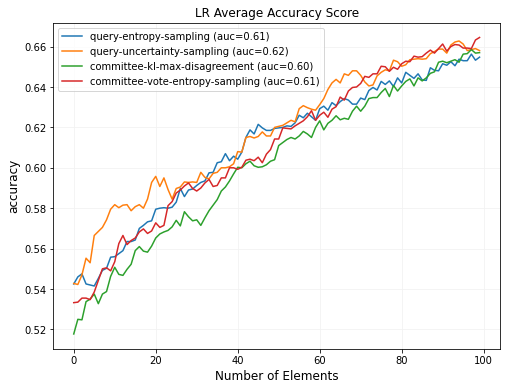

In [33]:
draw_graph(acc_list, algorithm=LR, title='LR Average Accuracy Score', y_label='accuracy')

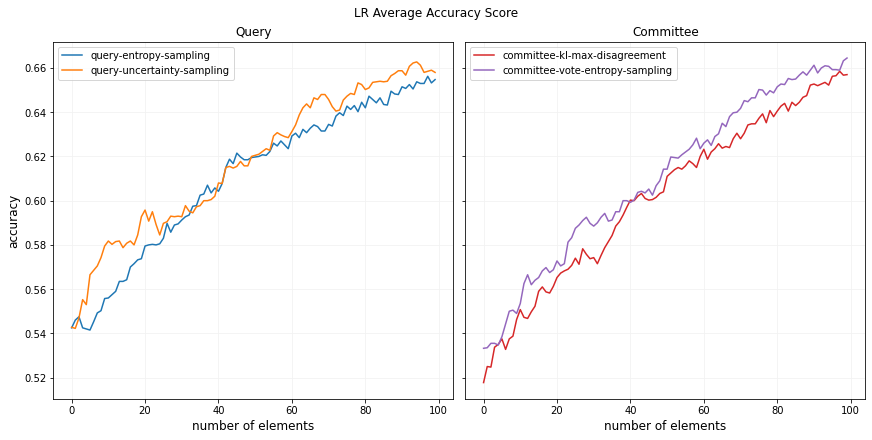

In [34]:
draw_graph_side(query, committee, 
                algorithm=LR, suptitle='LR Average Accuracy Score', 
                titles=TITLES, y_labels=Y_LABELS, labels=LABELS, colors=COLORS, errors=False)

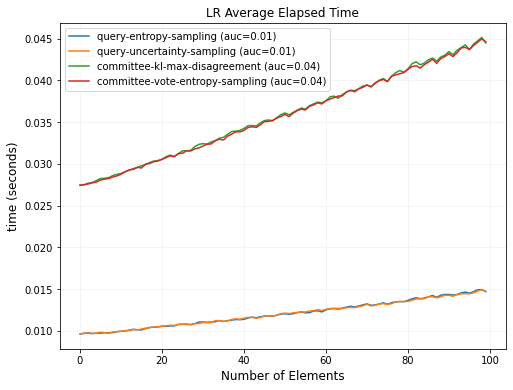

In [35]:
draw_graph(time_list, algorithm=LR, title='LR Average Elapsed Time', y_label='time (seconds)')

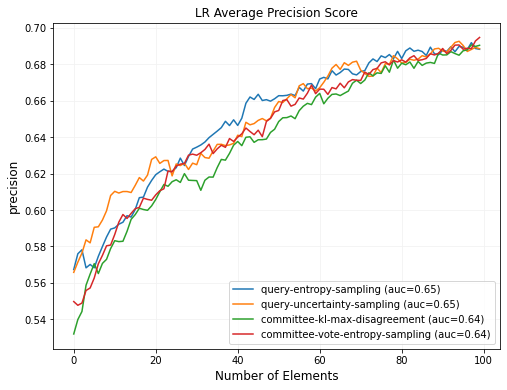

In [36]:
draw_graph(precision_list, algorithm=LR, title='LR Average Precision Score', y_label='precision')

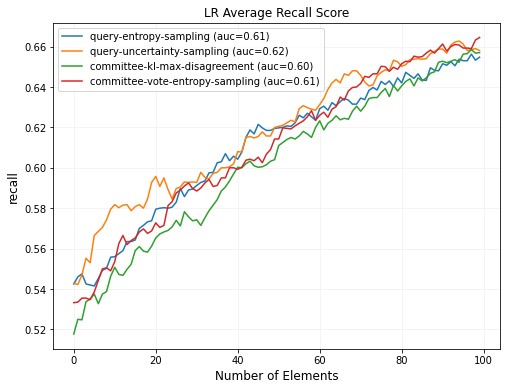

In [37]:
draw_graph(recall_list, algorithm=LR, title='LR Average Recall Score', y_label='recall')

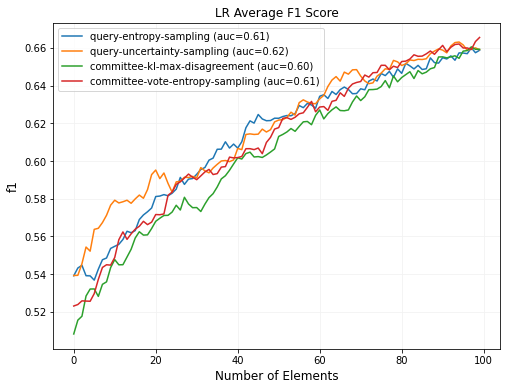

In [38]:
draw_graph(f1_list, algorithm=LR, title='LR Average F1 Score', y_label='f1')

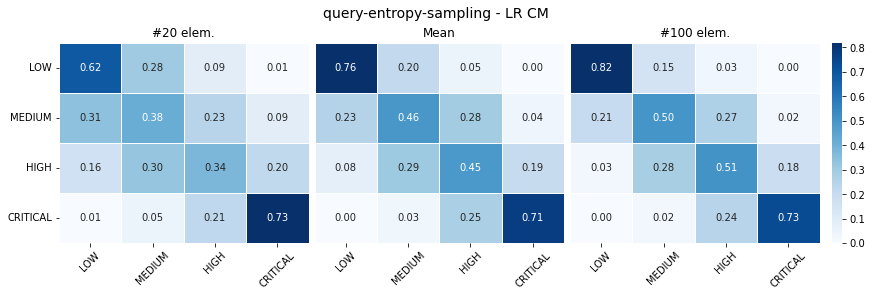

In [39]:
plot_confusion_matrix(cm_list, tech=ACTIVE_SUPER, algo=LR)

In [40]:
print_statistics(accs, LR)

#0 elements: max acc = 0.54 => best: query-uncertainty-sampling
#10 elements: max acc = 0.58 => best: query-uncertainty-sampling
#20 elements: max acc = 0.60 => best: query-uncertainty-sampling
#30 elements: max acc = 0.59 => best: query-uncertainty-sampling
#40 elements: max acc = 0.61 => best: query-uncertainty-sampling
#50 elements: max acc = 0.62 => best: query-uncertainty-sampling
#60 elements: max acc = 0.63 => best: query-uncertainty-sampling
#70 elements: max acc = 0.65 => best: query-uncertainty-sampling
#80 elements: max acc = 0.65 => best: committee-vote-entropy-sampling
#90 elements: max acc = 0.66 => best: committee-vote-entropy-sampling
#99 elements: max acc = 0.66 => best: committee-vote-entropy-sampling


## SVC Classifier

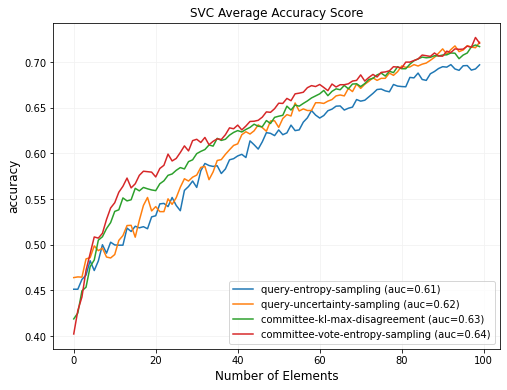

In [41]:
draw_graph(acc_list, algorithm=SVC, title='SVC Average Accuracy Score', y_label='accuracy')

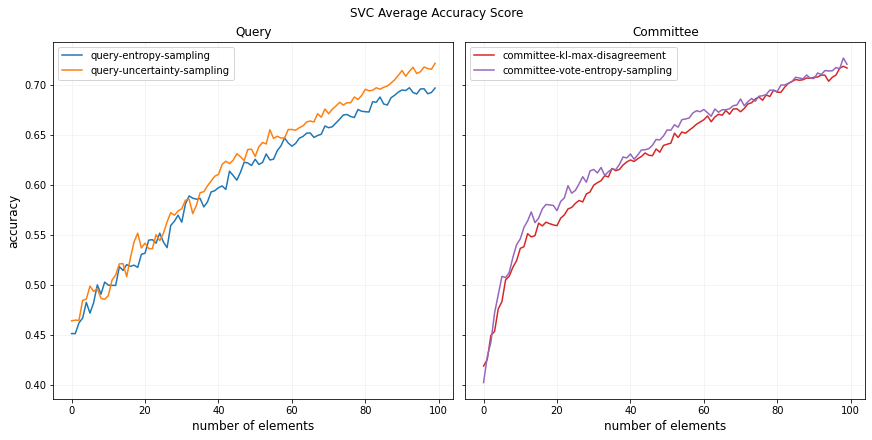

In [42]:
draw_graph_side(query, committee, 
                algorithm=SVC, suptitle='SVC Average Accuracy Score', 
                titles=TITLES, y_labels=Y_LABELS, labels=LABELS, colors=COLORS, errors=False)

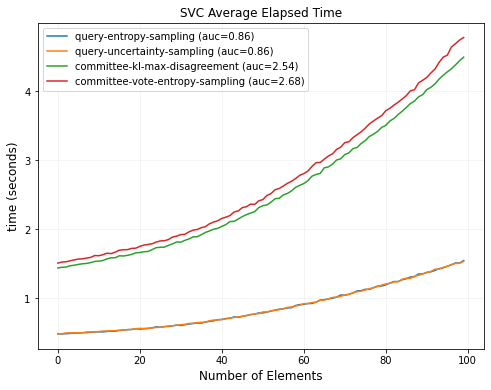

In [43]:
draw_graph(time_list, algorithm=SVC, title='SVC Average Elapsed Time', y_label='time (seconds)')

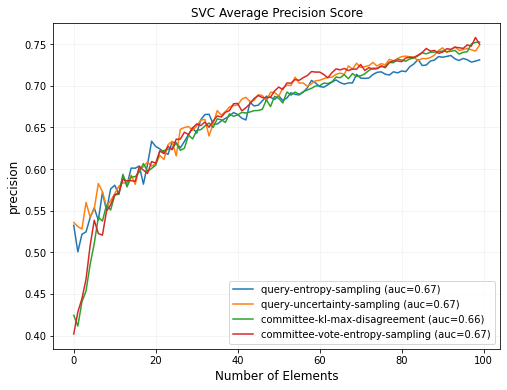

In [44]:
draw_graph(precision_list, algorithm=SVC, title='SVC Average Precision Score', y_label='precision')

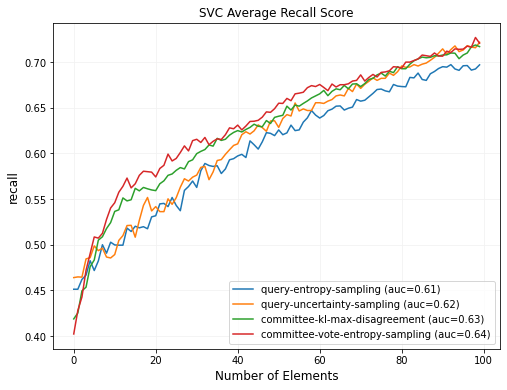

In [45]:
draw_graph(recall_list, algorithm=SVC, title='SVC Average Recall Score', y_label='recall')

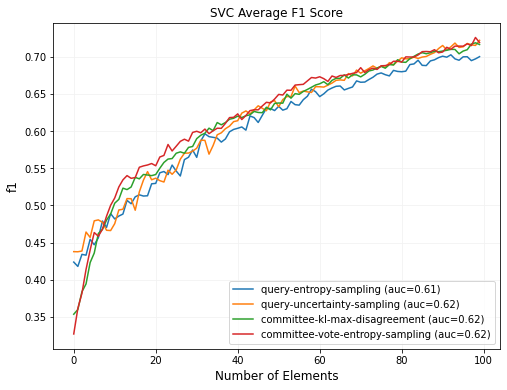

In [46]:
draw_graph(f1_list, algorithm=SVC, title='SVC Average F1 Score', y_label='f1')

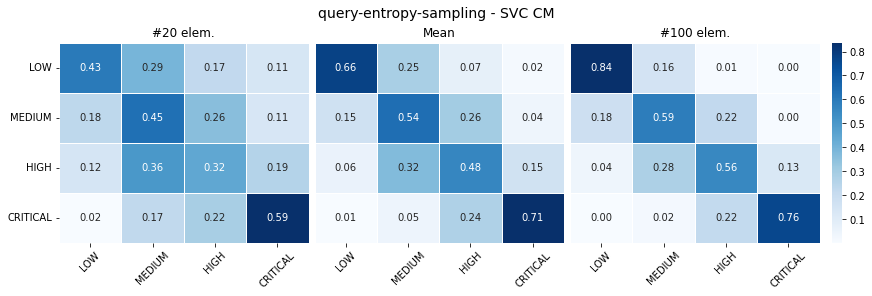

In [47]:
plot_confusion_matrix(cm_list, tech=ACTIVE_SUPER, algo=SVC)

In [48]:
print_statistics(accs, SVC)

#0 elements: max acc = 0.46 => best: query-uncertainty-sampling
#10 elements: max acc = 0.55 => best: committee-vote-entropy-sampling
#20 elements: max acc = 0.57 => best: committee-vote-entropy-sampling
#30 elements: max acc = 0.62 => best: committee-vote-entropy-sampling
#40 elements: max acc = 0.63 => best: committee-vote-entropy-sampling
#50 elements: max acc = 0.66 => best: committee-vote-entropy-sampling
#60 elements: max acc = 0.68 => best: committee-vote-entropy-sampling
#70 elements: max acc = 0.69 => best: committee-vote-entropy-sampling
#80 elements: max acc = 0.70 => best: query-uncertainty-sampling
#90 elements: max acc = 0.71 => best: query-uncertainty-sampling
#99 elements: max acc = 0.72 => best: query-uncertainty-sampling


## MLP Classifier

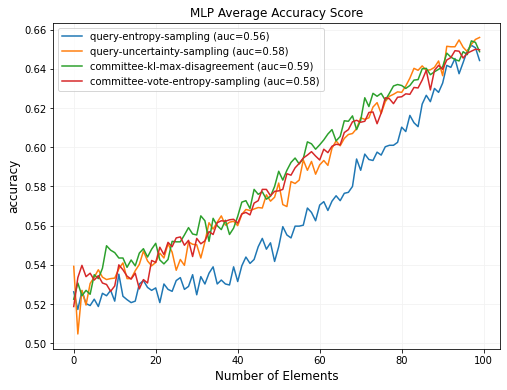

In [49]:
draw_graph(acc_list, algorithm=MLP, title='MLP Average Accuracy Score', y_label='accuracy')

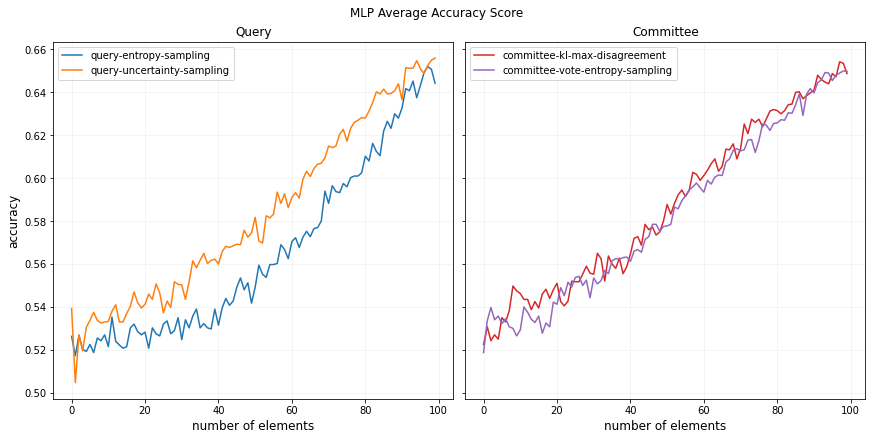

In [50]:
draw_graph_side(query, committee, 
                algorithm=MLP, suptitle='MLP Average Accuracy Score', 
                titles=TITLES, y_labels=Y_LABELS, labels=LABELS, colors=COLORS, errors=False)

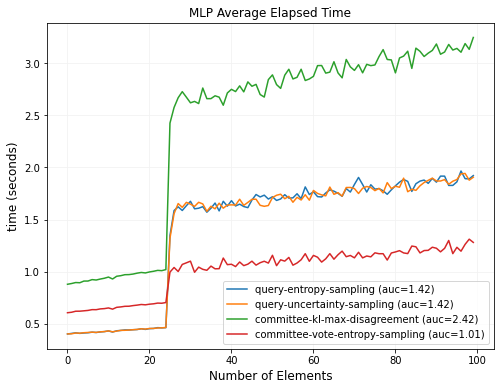

In [51]:
draw_graph(time_list, algorithm=MLP, title='MLP Average Elapsed Time', y_label='time (seconds)')

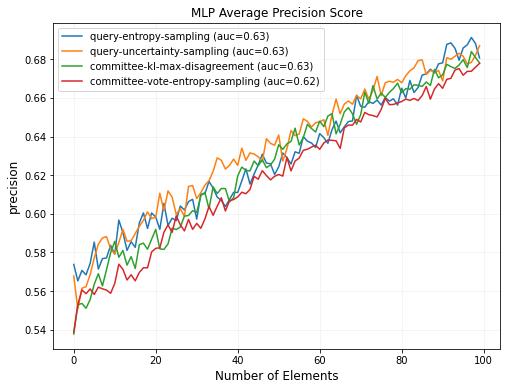

In [52]:
draw_graph(precision_list, algorithm=MLP, title='MLP Average Precision Score', y_label='precision')

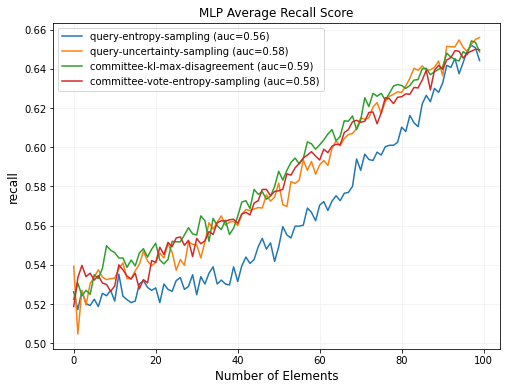

In [53]:
draw_graph(recall_list, algorithm=MLP, title='MLP Average Recall Score', y_label='recall')

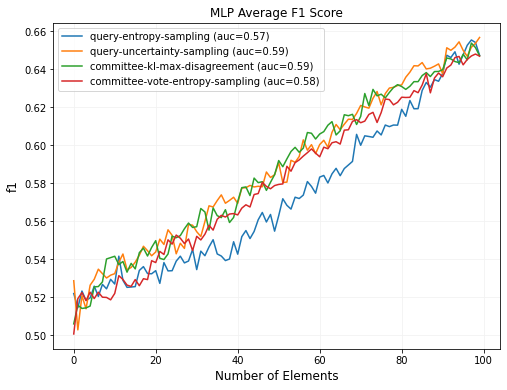

In [54]:
draw_graph(f1_list, algorithm=MLP, title='MLP Average F1 Score', y_label='f1')

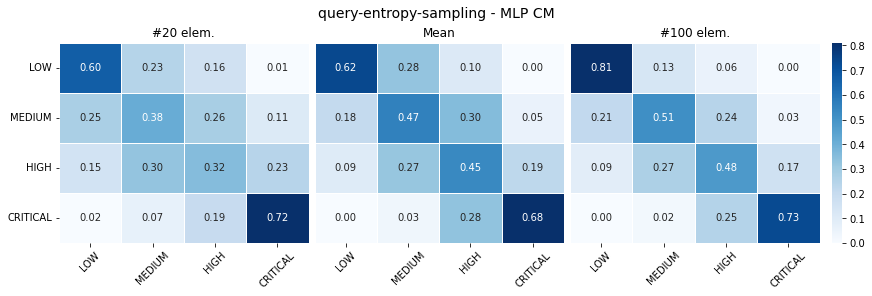

In [55]:
plot_confusion_matrix(cm_list, tech=ACTIVE_SUPER, algo=MLP)

In [56]:
print_statistics(accs, MLP)

#0 elements: max acc = 0.54 => best: query-uncertainty-sampling
#10 elements: max acc = 0.55 => best: committee-kl-max-disagreement
#20 elements: max acc = 0.55 => best: committee-kl-max-disagreement
#30 elements: max acc = 0.56 => best: committee-kl-max-disagreement
#40 elements: max acc = 0.56 => best: committee-kl-max-disagreement
#50 elements: max acc = 0.59 => best: committee-kl-max-disagreement
#60 elements: max acc = 0.60 => best: committee-kl-max-disagreement
#70 elements: max acc = 0.61 => best: query-uncertainty-sampling
#80 elements: max acc = 0.63 => best: committee-kl-max-disagreement
#90 elements: max acc = 0.64 => best: committee-kl-max-disagreement
#99 elements: max acc = 0.66 => best: query-uncertainty-sampling


## Global statistics

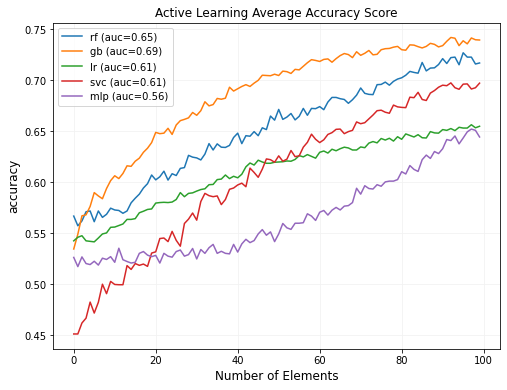

In [57]:
draw_graph(acc_list, algorithm=ACTIVE_SUPER, 
           title='Active Learning Average Accuracy Score', y_label='accuracy', 
           errors=False, single_tech=True)

In [58]:
find_best_classifier(accs)

For #0 elements, the best classifier is RF using query-entropy-sampling with 0.57 score.
For #10 elements, the best classifier is GB using query-uncertainty-sampling with 0.61 score.
For #20 elements, the best classifier is GB using query-uncertainty-sampling with 0.66 score.
For #30 elements, the best classifier is GB using query-uncertainty-sampling with 0.68 score.
For #40 elements, the best classifier is GB using query-uncertainty-sampling with 0.70 score.
For #50 elements, the best classifier is GB using committee-kl-max-disagreement with 0.71 score.
For #60 elements, the best classifier is GB using query-uncertainty-sampling with 0.72 score.
For #70 elements, the best classifier is GB using query-uncertainty-sampling with 0.73 score.
For #80 elements, the best classifier is GB using query-uncertainty-sampling with 0.73 score.
For #90 elements, the best classifier is GB using query-uncertainty-sampling with 0.74 score.
For #99 elements, the best classifier is GB using query-entrop

# Thesis Graphs and Tables

In [59]:
techs_names = [
    'query-entropy-sampling', 'query-uncertainty-sampling', 
    'committee-kl-max-disagreement', 'committee-vote-entropy-sampling'
]

learners = [RF, GB, LR, SVC, MLP]
learners_names = ['rf', 'gb', 'lr', 'svc', 'mlp']

for index, (learner, learner_name) in enumerate(zip(learners, learners_names)):
    print(f'\n# {learner_name.upper()}')
    
    for tech, acc, std in zip(techs_names, accs, stds):
        print(f' - {tech.upper()}: {acc[index][-1]:.2f} (-+{std[index][-1]:.2f})')  


# RF
 - QUERY-ENTROPY-SAMPLING: 0.72 (-+0.08)
 - QUERY-UNCERTAINTY-SAMPLING: 0.73 (-+0.07)
 - COMMITTEE-KL-MAX-DISAGREEMENT: 0.73 (-+0.08)
 - COMMITTEE-VOTE-ENTROPY-SAMPLING: 0.73 (-+0.08)

# GB
 - QUERY-ENTROPY-SAMPLING: 0.74 (-+0.07)
 - QUERY-UNCERTAINTY-SAMPLING: 0.74 (-+0.07)
 - COMMITTEE-KL-MAX-DISAGREEMENT: 0.72 (-+0.08)
 - COMMITTEE-VOTE-ENTROPY-SAMPLING: 0.72 (-+0.08)

# LR
 - QUERY-ENTROPY-SAMPLING: 0.65 (-+0.08)
 - QUERY-UNCERTAINTY-SAMPLING: 0.66 (-+0.08)
 - COMMITTEE-KL-MAX-DISAGREEMENT: 0.66 (-+0.08)
 - COMMITTEE-VOTE-ENTROPY-SAMPLING: 0.66 (-+0.07)

# SVC
 - QUERY-ENTROPY-SAMPLING: 0.70 (-+0.08)
 - QUERY-UNCERTAINTY-SAMPLING: 0.72 (-+0.07)
 - COMMITTEE-KL-MAX-DISAGREEMENT: 0.72 (-+0.08)
 - COMMITTEE-VOTE-ENTROPY-SAMPLING: 0.72 (-+0.08)

# MLP
 - QUERY-ENTROPY-SAMPLING: 0.64 (-+0.08)
 - QUERY-UNCERTAINTY-SAMPLING: 0.66 (-+0.08)
 - COMMITTEE-KL-MAX-DISAGREEMENT: 0.65 (-+0.08)
 - COMMITTEE-VOTE-ENTROPY-SAMPLING: 0.65 (-+0.08)


In [60]:
techs_names = ['query-entropy-sampling', 'query-uncertainty-sampling']
algo = GB

for tech, name in zip(range(2), techs_names):
    precision = precisions[tech][algo][-1]
    precision_sd = precisions_std[tech][algo][-1]

    recall = recalls[tech][algo][-1]
    recall_sd = recalls_std[tech][algo][-1]

    f1 = f1s[tech][algo][-1]
    f1_sd = f1s_std[tech][algo][-1]

    print(f'# {name}')
    print(f'  - Precision: {precision:.2f} (+-{precision_sd:.2f})')
    print(f'  - Recall: {recall:.2f} (+-{recall_sd:.2f})')
    print(f'  - F1-score: {f1:.2f} (+-{f1_sd:.2f})\n')

# query-entropy-sampling
  - Precision: 0.76 (+-0.08)
  - Recall: 0.74 (+-0.07)
  - F1-score: 0.74 (+-0.07)

# query-uncertainty-sampling
  - Precision: 0.76 (+-0.08)
  - Recall: 0.74 (+-0.07)
  - F1-score: 0.74 (+-0.07)



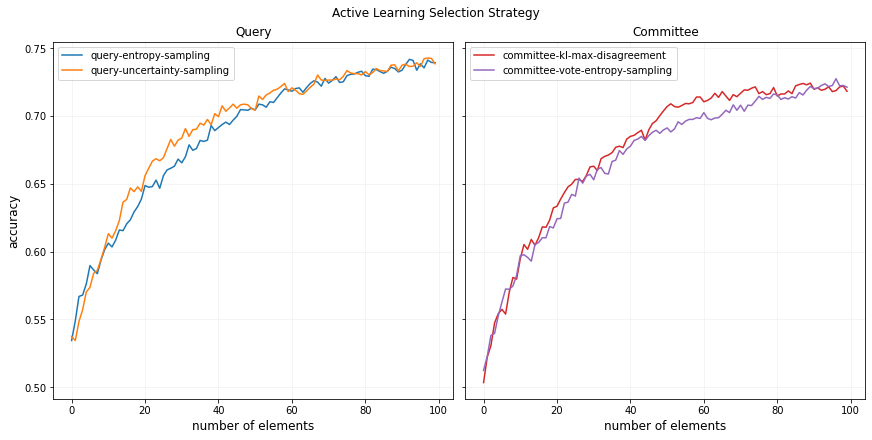

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True, sharey=True)
    
values = [query, committee]
titles = ['Query', 'Committee']
y_labels = ['accuracy', '']
labels = [TECHS[:2], TECHS[2:]]
colors=COLORS
algorithm = GB

fig.suptitle("Active Learning Selection Strategy") 

for ax, (scores, stds), title, y_label, label, color in zip(axes, values, titles, y_labels, labels, colors):
    _score = [i[algorithm] for i in scores]

    for score in scores:
        _score = [i[algorithm] for i in scores]
    
    for y, lab, col in zip(_score, label, color):
        ax.plot(RANGES, y, label=lab, color=col)

    ax.set_title(title, size=12)
    ax.set_xlabel('number of elements', size=12)
    ax.set_ylabel(y_label, size=12)
    ax.grid(color='0.95')
    ax.legend()

In [62]:
query_accs, query_std = query

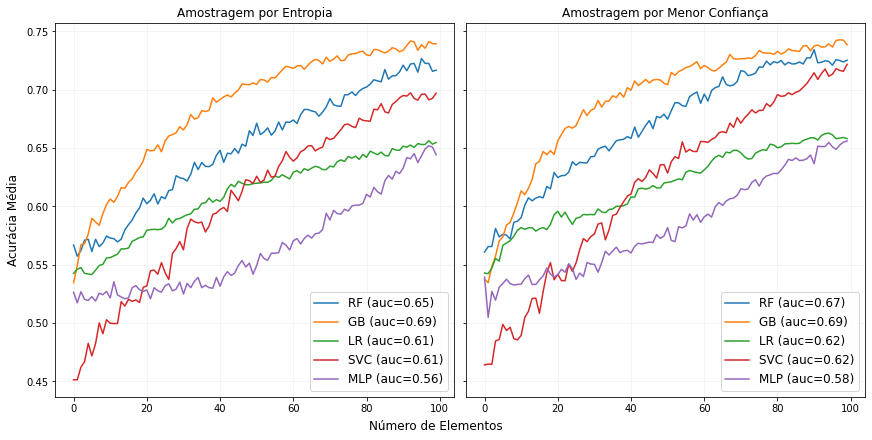

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True, sharey=True)

query_accs, query_std = query
strategies = ['Amostragem por Entropia', 'Amostragem por Menor Confiança']
learners = ['rf', 'gb', 'lr', 'svc', 'mlp']

for ax, accs, strategy in zip(axes, query_accs, strategies):
    
    for learner, acc in zip(learners, accs):
        label = f'{learner.upper()} (auc={auc(np.linspace(0, 1, 100), acc):.2f})'
        ax.plot(RANGES, acc, label=label)
        
    ax.set_title(strategy, size=12)
    ax.grid(color='0.95')
    ax.legend(fontsize=12)

# fig.suptitle('Estratégia de Amostragem por Incerteza', size=12)
fig.supxlabel('Número de Elementos', size=12)
fig.supylabel('Acurácia Média', size=12)

plt.savefig('query-strategy-curve.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

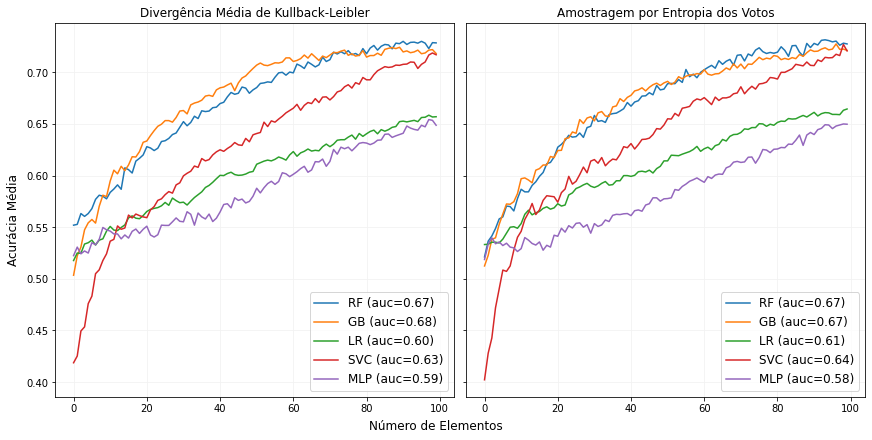

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True, sharey=True)

committee_accs, committee_std = committee
strategies = ['Divergência Média de Kullback-Leibler','Amostragem por Entropia dos Votos']
learners = ['rf', 'gb', 'lr', 'svc', 'mlp']

for ax, accs, strategy in zip(axes, committee_accs, strategies):
    
    for learner, acc in zip(learners, accs):
        label = f'{learner.upper()} (auc={auc(np.linspace(0, 1, 100), acc):.2f})'
        ax.plot(RANGES, acc, label=label)
        
    ax.set_title(strategy, size=12)
    ax.grid(color='0.95')
    ax.legend(fontsize=12)

# fig.suptitle('Estratégia de Amostragem por Comitê', size=12)
fig.supxlabel('Número de Elementos', size=12)
fig.supylabel('Acurácia Média', size=12)

plt.savefig('committee-strategy-curve.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

In [65]:
techs_names = [
    'query-entropy-sampling', 'query-uncertainty-sampling', 
    'committee-kl-max-disagreement', 'committee-vote-entropy-sampling'
]

learners = [RF, GB, LR, SVC, MLP]
learners_names = ['rf', 'gb', 'lr', 'svc', 'mlp']

for index, (learner, learner_name) in enumerate(zip(learners, learners_names)):
    print(f'\n# {learner_name.upper()}')
    
    for tech, acc, std in zip(techs_names, times, times_std):
        print(f' - {tech.upper()}: {acc[index][-1]:.2f} (-+{std[index][-1]:.2f})')  


# RF
 - QUERY-ENTROPY-SAMPLING: 0.20 (-+0.00)
 - QUERY-UNCERTAINTY-SAMPLING: 0.20 (-+0.00)
 - COMMITTEE-KL-MAX-DISAGREEMENT: 0.59 (-+0.00)
 - COMMITTEE-VOTE-ENTROPY-SAMPLING: 0.59 (-+0.00)

# GB
 - QUERY-ENTROPY-SAMPLING: 0.52 (-+0.01)
 - QUERY-UNCERTAINTY-SAMPLING: 0.52 (-+0.00)
 - COMMITTEE-KL-MAX-DISAGREEMENT: 1.57 (-+0.02)
 - COMMITTEE-VOTE-ENTROPY-SAMPLING: 1.57 (-+0.01)

# LR
 - QUERY-ENTROPY-SAMPLING: 0.01 (-+0.00)
 - QUERY-UNCERTAINTY-SAMPLING: 0.01 (-+0.00)
 - COMMITTEE-KL-MAX-DISAGREEMENT: 0.04 (-+0.00)
 - COMMITTEE-VOTE-ENTROPY-SAMPLING: 0.04 (-+0.00)

# SVC
 - QUERY-ENTROPY-SAMPLING: 1.55 (-+0.09)
 - QUERY-UNCERTAINTY-SAMPLING: 1.54 (-+0.09)
 - COMMITTEE-KL-MAX-DISAGREEMENT: 4.49 (-+0.14)
 - COMMITTEE-VOTE-ENTROPY-SAMPLING: 4.78 (-+0.85)

# MLP
 - QUERY-ENTROPY-SAMPLING: 1.92 (-+0.48)
 - QUERY-UNCERTAINTY-SAMPLING: 1.91 (-+0.37)
 - COMMITTEE-KL-MAX-DISAGREEMENT: 3.25 (-+2.27)
 - COMMITTEE-VOTE-ENTROPY-SAMPLING: 1.28 (-+0.30)


In [66]:
scores, stds = time_list

query_times = scores[:2]
committee_times = scores[2:]

In [67]:
_query_times = list()
_committee_times = list()

for index, learner in enumerate(learners):
    _query_times.append((np.array(query_times[0][index]) + np.array(query_times[1][index])) / 2)
    _committee_times.append((np.array(committee_times[0][index]) + np.array(committee_times[1][index])) / 2)

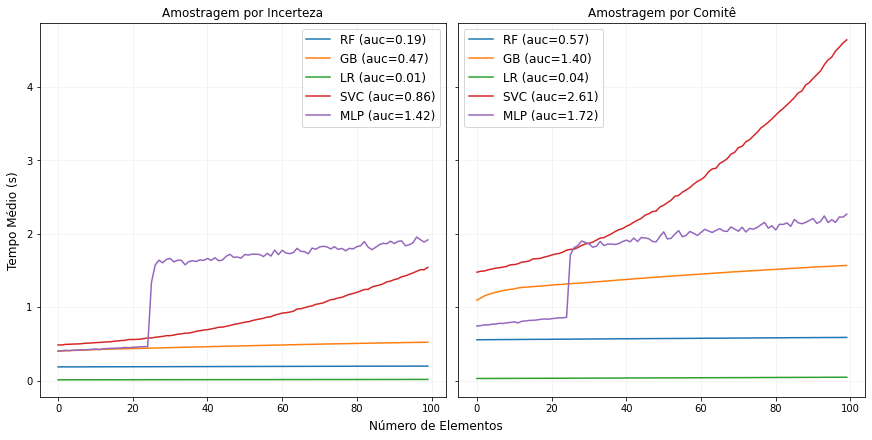

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True, sharey=True)

strategies = ['Amostragem por Incerteza','Amostragem por Comitê']
learners = ['rf', 'gb', 'lr', 'svc', 'mlp']

values = [_query_times, _committee_times]

for ax, accs, strategy in zip(axes, values, strategies):
    
    for learner, acc in zip(learners, accs):
        label = f'{learner.upper()} (auc={auc(np.linspace(0, 1, 100), acc):.2f})'
        ax.plot(RANGES, acc, label=label)
        
    ax.set_title(strategy, size=12)
    ax.grid(color='0.95')
    ax.legend(fontsize=12)

# fig.suptitle('Estratégia de Amostragem por Comitê', size=12)
fig.supxlabel('Número de Elementos', size=12)
fig.supylabel('Tempo Médio (s)', size=12)

plt.savefig('query-strategy-time-curve.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()